In [1]:
import sys
sys.path.insert(0, "../..")

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from logistic_regression import LogisticRegressionGD
from extrapolation import *
from experiments import Experiment, RestartingExperiment

In [3]:
device = "cpu"

X = []
with open("../../../madelon_train.data") as f:
    for line in f:
        X.append([float(x) for x in line.split()])
X = np.array(X)
X /= X.max()
X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X = torch.tensor(X, device=device)
with open("../../../madelon_train.labels") as f:
    y = [int(x) for x in f]
y = torch.tensor(y, device=device)
X.shape, y.shape

(torch.Size([2000, 501]), torch.Size([2000]))

In [4]:
np.random.seed(2020)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

## $\tau = 10^{-3}$

In [6]:
model = LogisticRegressionGD(X_train, y_train, 1e-3, device=device)

In [ ]:
model.fit(1e-8, max_iter=100500)

/opt/miniconda3/envs/torch/lib/python3.8/site-packages/torch/autograd/__init__.py:145: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378065146/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(


In [10]:
len(model.log)

100501

In [11]:
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5600, dtype=torch.float64)

### Without restarting

In [12]:
experiment = Experiment(model.log, model.obj, values=model.value_log)

In [13]:
experiment.run_method("VLT", h_algorithm, 5, method_kwargs={"k": 4, "type": "t"})

In [14]:
experiment.run_method("VLU", h_algorithm, 5, method_kwargs={"k": 4, "type": "u"})

In [15]:
experiment.run_method("VLV", h_algorithm, 6, method_kwargs={"k": 4, "type": "v"})

In [16]:
experiment.run_method("RRE+QR", RRE, 4, method_kwargs={"qr": True})

In [17]:
experiment.run_method("Epsilon inv", vector_epsilon_v1, 8, method_kwargs={"k": 4})

In [18]:
k = 4
n = 5
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [19]:
experiment.run_method("VJT", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "t"})

In [20]:
experiment.run_method("VJU", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "u"})

In [21]:
k = 4
n = 6
p = 7
m = np.arange(n)[None, :] + 1 + (p - 1) * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [22]:
experiment.run_method("VJV", j_algorithm, 6, method_kwargs={"deltas": deltas, "type": "v"})

In [23]:
k = 4
n = 5
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [24]:
experiment.run_method("VST", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "t"})

In [25]:
experiment.run_method("VSU", j_algorithm, 5, method_kwargs={"deltas": deltas, "type": "u"})

In [26]:
k = 4
n = 6
p = 3
m = np.arange(n)[None, :] + 1 + 2 * np.arange(k)[:, None]
deltas = 1 / (m * (m + 1))

In [27]:
experiment.run_method("VSV", j_algorithm, 6, method_kwargs={"deltas": deltas, "type": "v"})

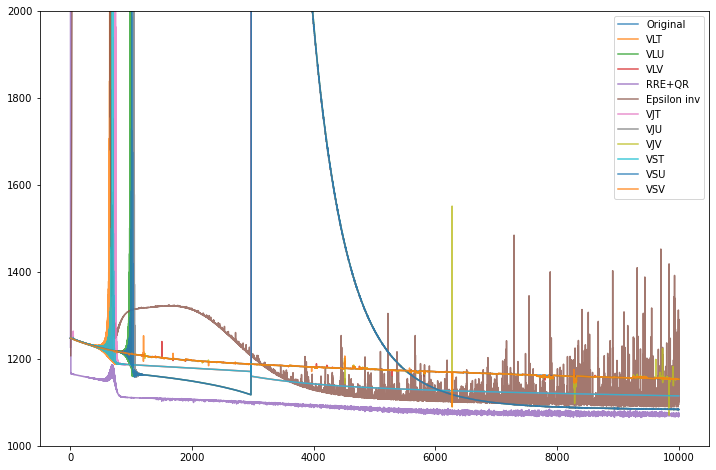

In [37]:
experiment.plot_values(n=10000, ylim=(1000, 2000), figsize=(12, 8))

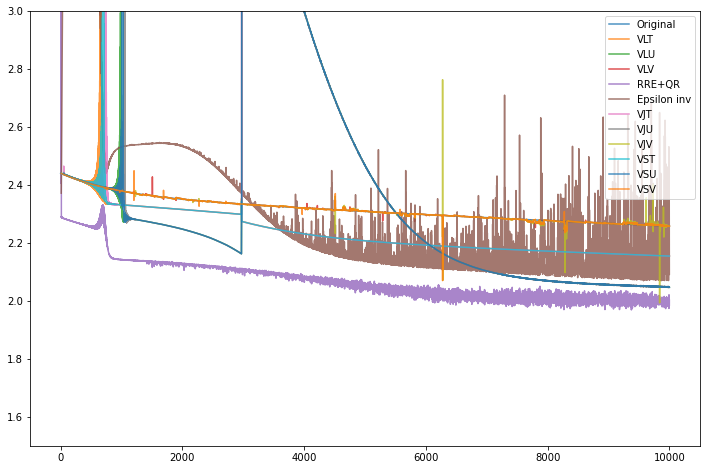

In [39]:
experiment.plot_log_diff(n=10000, figsize=(12, 8), ylim=(1.5, 3))

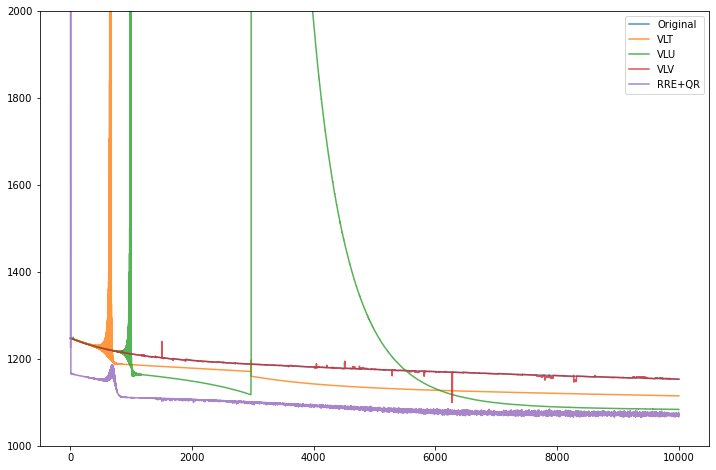

In [45]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(1000, 2000),
                      methods=["VLT", "VLU", "VLV", "RRE+QR"])

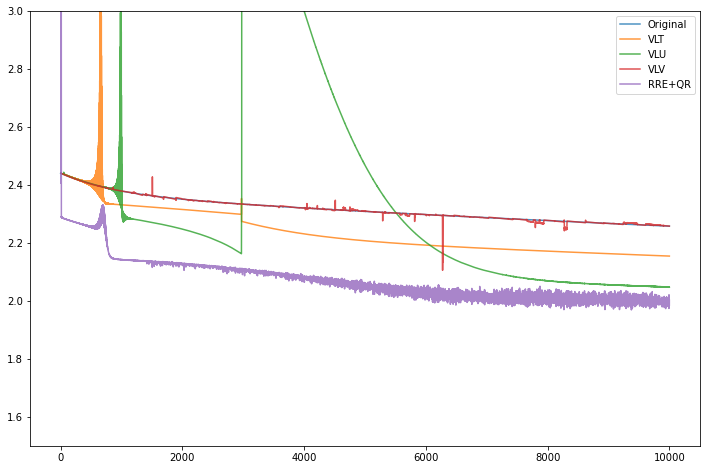

In [46]:
experiment.plot_log_diff(n=10000, figsize=(12, 8), ylim=(1.5, 3),
                      methods=["VLT", "VLU", "VLV", "RRE+QR"])

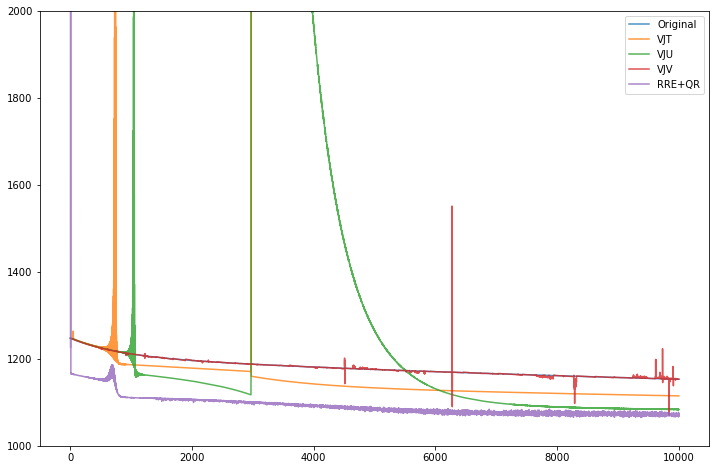

In [40]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(1000, 2000),
                      methods=["VJT", "VJU", "VJV", "RRE+QR"])

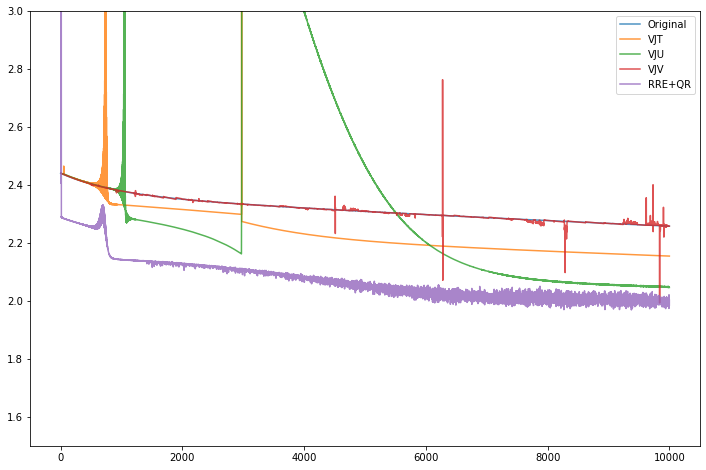

In [41]:
experiment.plot_log_diff(n=10000, figsize=(12, 8), ylim=(1.5, 3),
                      methods=["VJT", "VJU", "VJV", "RRE+QR"])

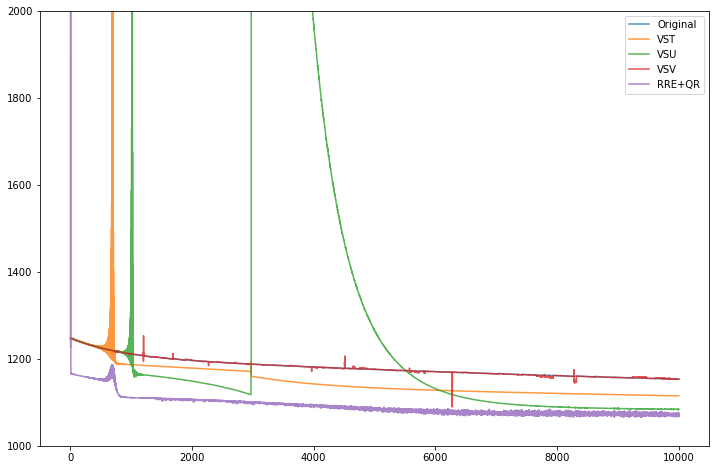

In [42]:
experiment.plot_values(n=10000, figsize=(12, 8), ylim=(1000, 2000),
                      methods=["VST", "VSU", "VSV", "RRE+QR"])

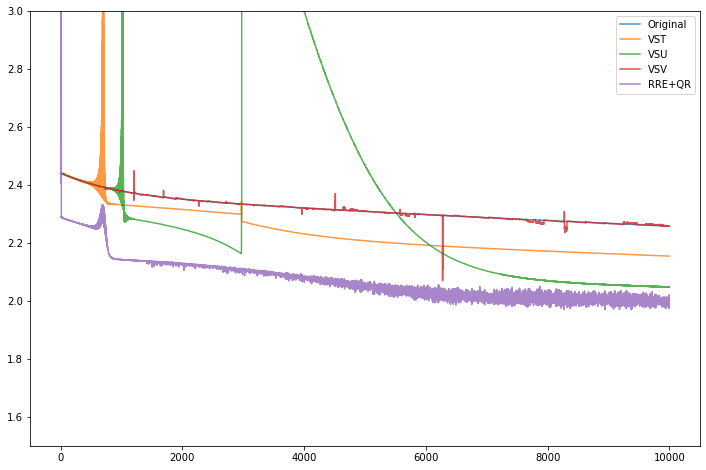

In [43]:
experiment.plot_log_diff(n=10000, figsize=(12, 8), ylim=(1.5, 3),
                      methods=["VST", "VSU", "VSV", "RRE+QR"])

In [44]:
model.theta = experiment.best_x
preds = model.predict(X_test)
torch.mean((preds == y_test).double())

tensor(0.5450, dtype=torch.float64)